<a href="https://colab.research.google.com/github/benafshapostwala/NLP_Real_Disaster_or_not/blob/main/NLP_Disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting google drive (because that's where my data is)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
random_state_split = 2
Dropout_num = 0
learning_rate = 6e-6
valid = 0.15
epochs_num = 3
batch_size_num = 16
target_corrected = False
target_big_corrected = False

Import libraries

In [3]:
import nltk
nltk.download('stopwords')

  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import torch

import warnings
warnings.simplefilter('ignore')

import the datasets

In [5]:
tweet= pd.read_csv('/content/gdrive/My Drive/NLP_Disaster_tweet_data/train.csv')
test=pd.read_csv('/content/gdrive/My Drive/NLP_Disaster_tweet_data/test.csv')
submission = pd.read_csv("/content/gdrive/My Drive/NLP_Disaster_tweet_data/sample_submission.csv")

In [6]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))
tweet.head(10)

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Checking class distribution

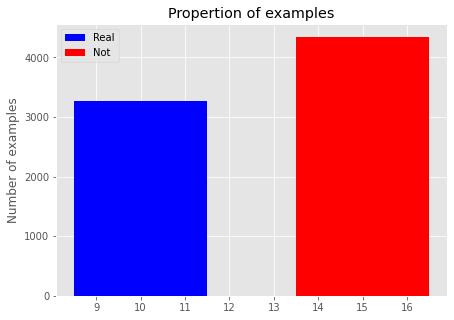

In [7]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]

# bar plot of the 2 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()


Create another column that consistes of the number of chararacters in each tweet

In [8]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

tweet['length'] = tweet['text'].apply(length)
tweet.head(10)

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,110
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,95
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,59
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,79
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,52


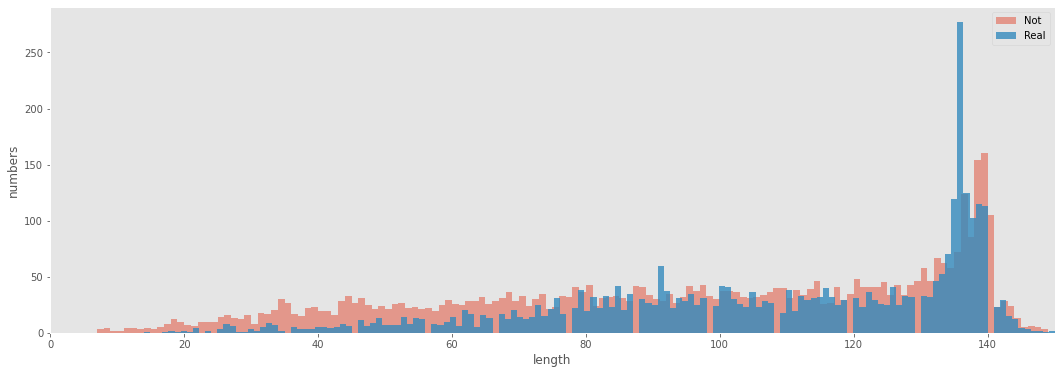

In [9]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.5, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

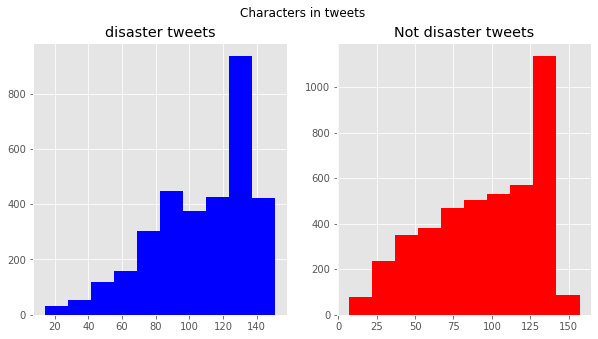

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Figure out the number of words in tweets

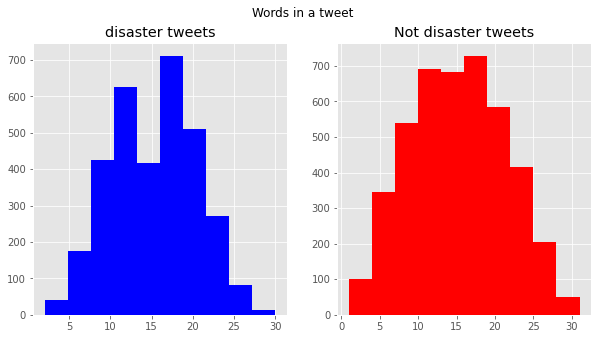

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

determining the average word length in each type of tweet

Text(0.5, 0.98, 'Average word length in each tweet')

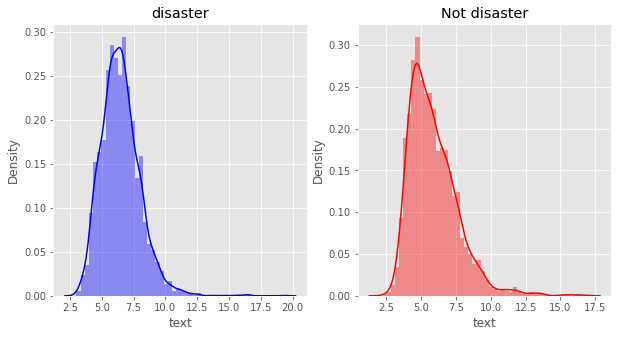

In [12]:
ig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [13]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [14]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Stopwords in Tweets

In [15]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
np.array(stop)

array({'but', 'now', 'm', 'don', 'ourselves', 'll', 'was', 'isn', 'this', 've', 'why', 'after', 'should', 'from', 'aren', 'yours', 'where', 'in', 'them', "shan't", 'against', "you'll", 'during', "hadn't", 'than', 'wouldn', 'such', "you'd", 'mustn', 'at', 'of', 'we', 'and', 'further', 'until', 'out', 're', "aren't", 'up', 'will', 'shan', 'whom', 'into', 'no', 'its', 'you', 'having', 'any', 'been', 'myself', 'they', "mustn't", "wasn't", 'hers', 'if', 'can', 'before', 'an', 'wasn', 'are', "doesn't", 'himself', 'too', 'yourselves', 'my', 'does', 'again', 'so', 'shouldn', 'to', 'about', 'both', "weren't", "she's", 'once', 'ain', 'ma', "haven't", 'under', 'did', 'have', 'hasn', 'more', 'i', 'down', 'below', "mightn't", "wouldn't", 'themselves', 'or', 'some', "couldn't", 'by', 't', 'only', 'then', "you've", 'it', 'there', 'him', 'those', 'didn', 'won', 'yourself', 'these', 'am', 'is', 'through', "that'll", 'she', "it's", 'off', 'needn', 'weren', 'between', 'her', 'a', 'herself', 'for', 'itsel

<BarContainer object of 10 artists>

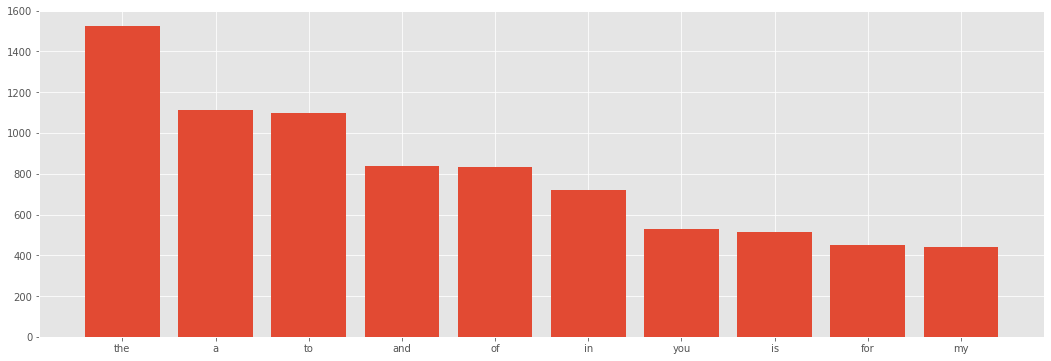

In [16]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

for class 1:

<BarContainer object of 10 artists>

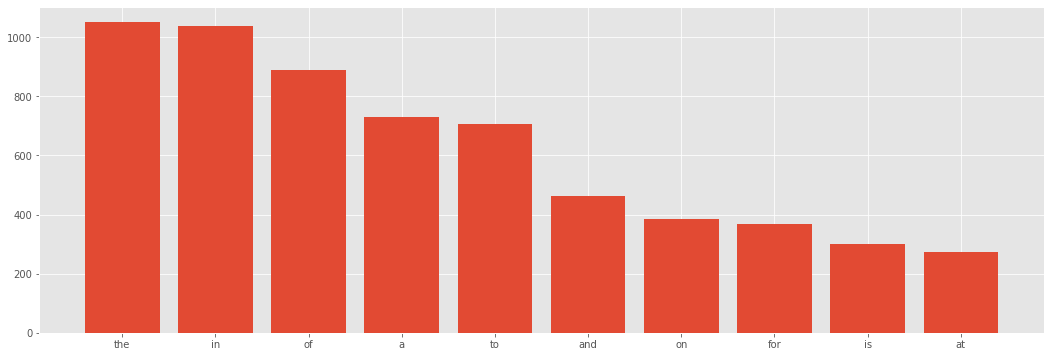

In [17]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

Analyzing punctuations for class 1

<BarContainer object of 18 artists>

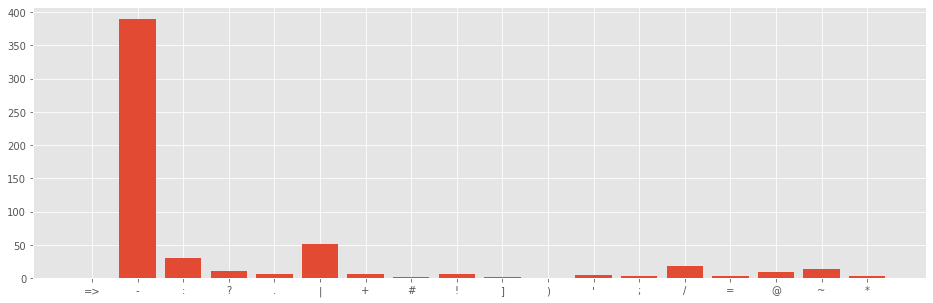

In [18]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Analyzing punctuation for class 0

<BarContainer object of 20 artists>

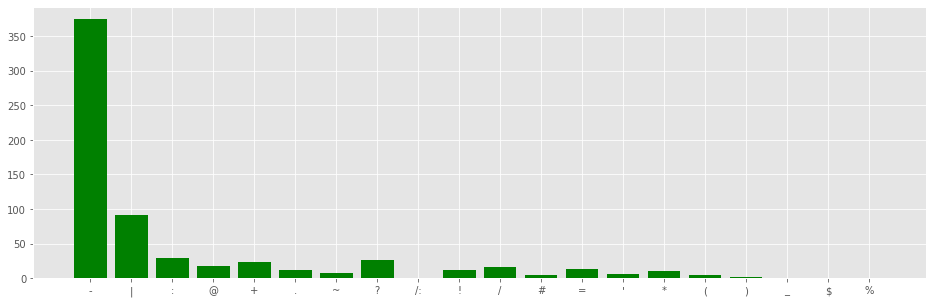

In [19]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

Visualizing common words

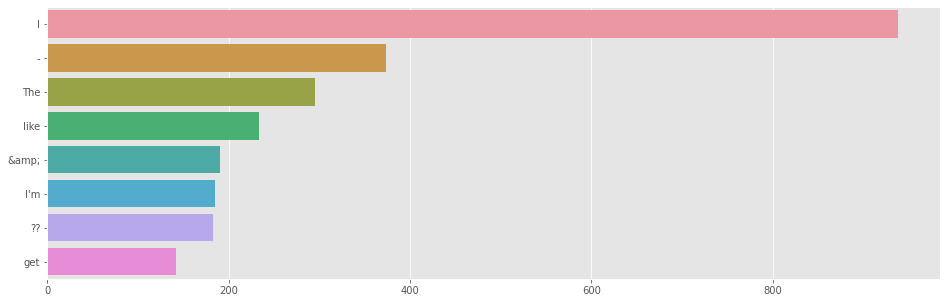

In [20]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

N-gram analysis (bigram)

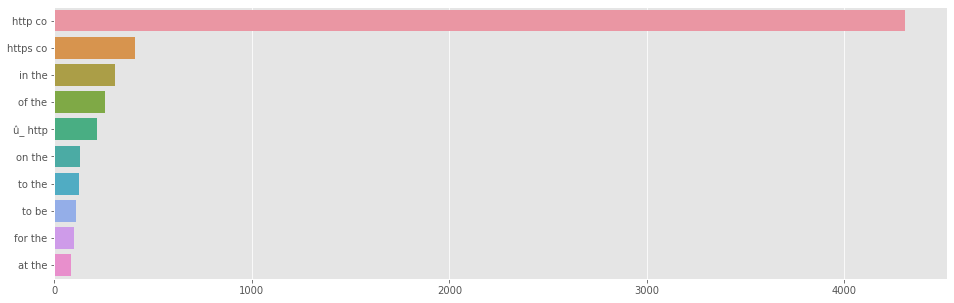

In [21]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [22]:
df=pd.concat([tweet,test])
df.shape

(10876, 6)

Removing URL

In [23]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_URL(x))

Remove HTML Tags

In [24]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

Remove Emojis

In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

Remove Punctuations

In [26]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

Word Cloud

Real disaster

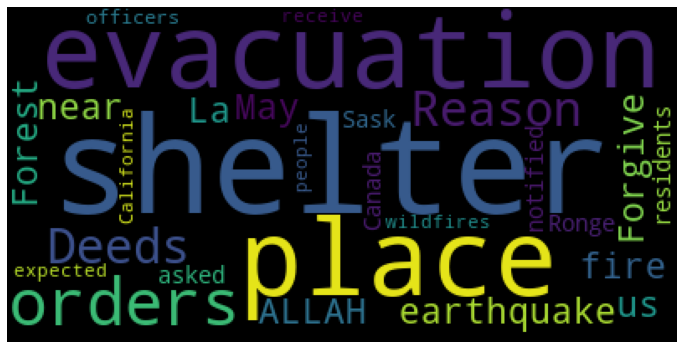

In [27]:
corpus_new1=create_corpus_df(df,1)
len(corpus_new1)
corpus_new1[:10]
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Word cloud for not a disaster

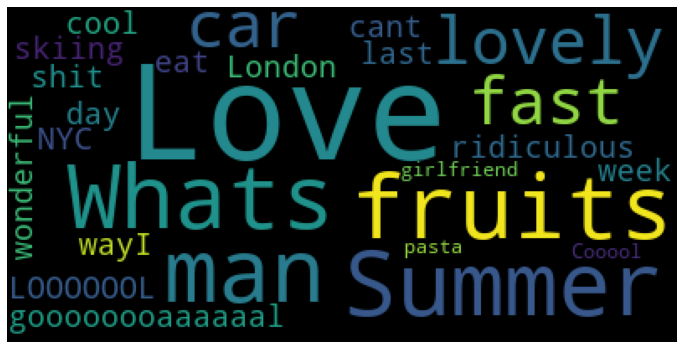

In [28]:
corpus_new0=create_corpus_df(df,0)
len(corpus_new0)
corpus_new0[:10]
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [29]:
df.head(10)

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,69.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,38.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,133.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,65.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,88.0
5,8,NaN,NaN,RockyFire Update California Hwy 20 closed in ...,1.0,110.0
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1.0,95.0
7,13,NaN,NaN,Im on top of the hill and I can see a fire in ...,1.0,59.0
8,14,NaN,NaN,Theres an emergency evacuation happening now i...,1.0,79.0
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1.0,52.0


Bag of Words

In [30]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=random_state_split)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Visualize the embeddings

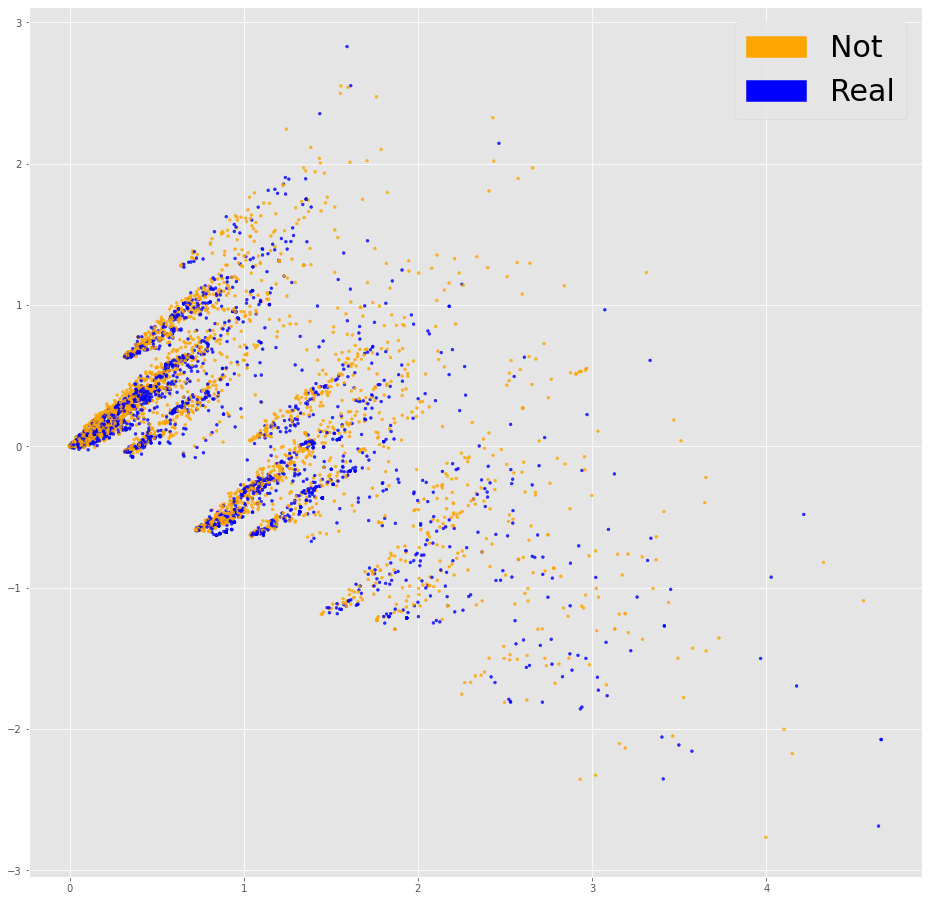

In [31]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

TFIDF - Term Frequency - Inverse Dense Frequency

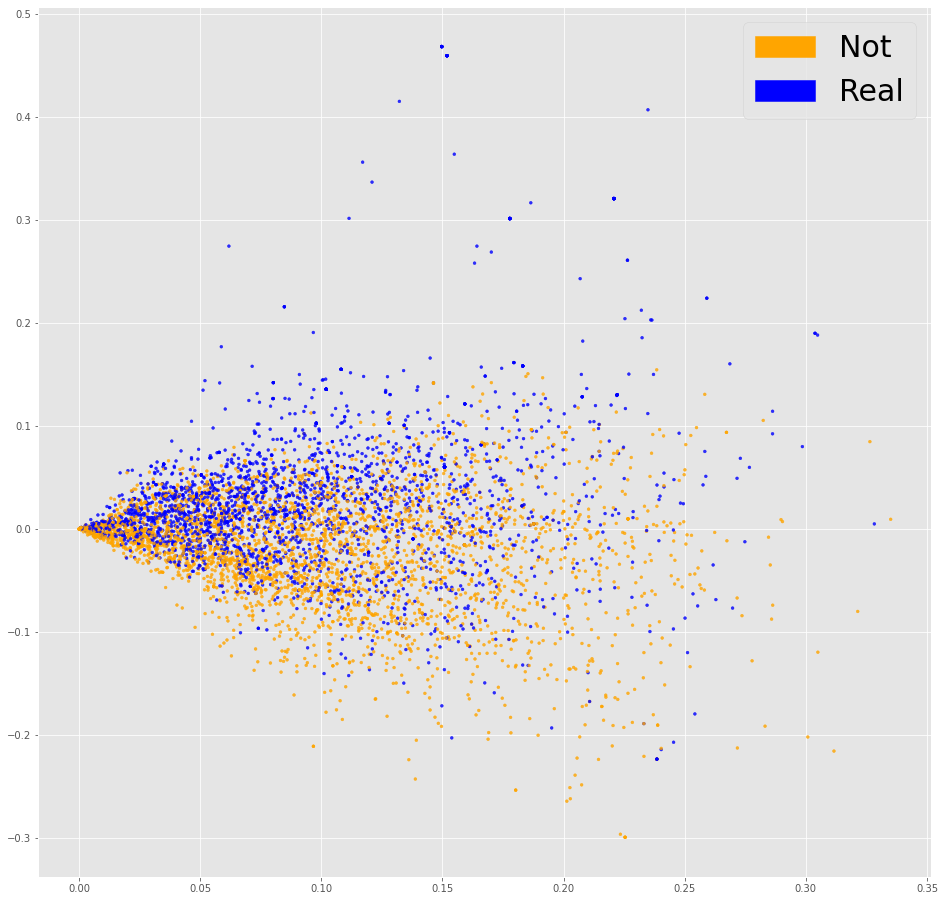

In [32]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

GloVe - global vectors for word representation

In [33]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [34]:
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   
corpus=create_corpus_new(df)

100%|██████████| 10876/10876 [00:01<00:00, 7402.50it/s]


In [35]:
embedding_dict={}
with open('/content/gdrive/My Drive/NLP_Disaster_tweet_data/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [36]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 22807


In [37]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec    

100%|██████████| 22807/22807 [00:00<00:00, 525746.04it/s]


In [38]:
tweet_pad[0][0:]

array([ 100, 5778,   20,    1,  814,    5,   18,  237,  136, 1902, 3703,
         68,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

Baseline model using GloVe results


In [39]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2280800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,361,301
Trainable params: 80,501
Non-trainable params: 2,280,800
_________________________________________________________________


In [40]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


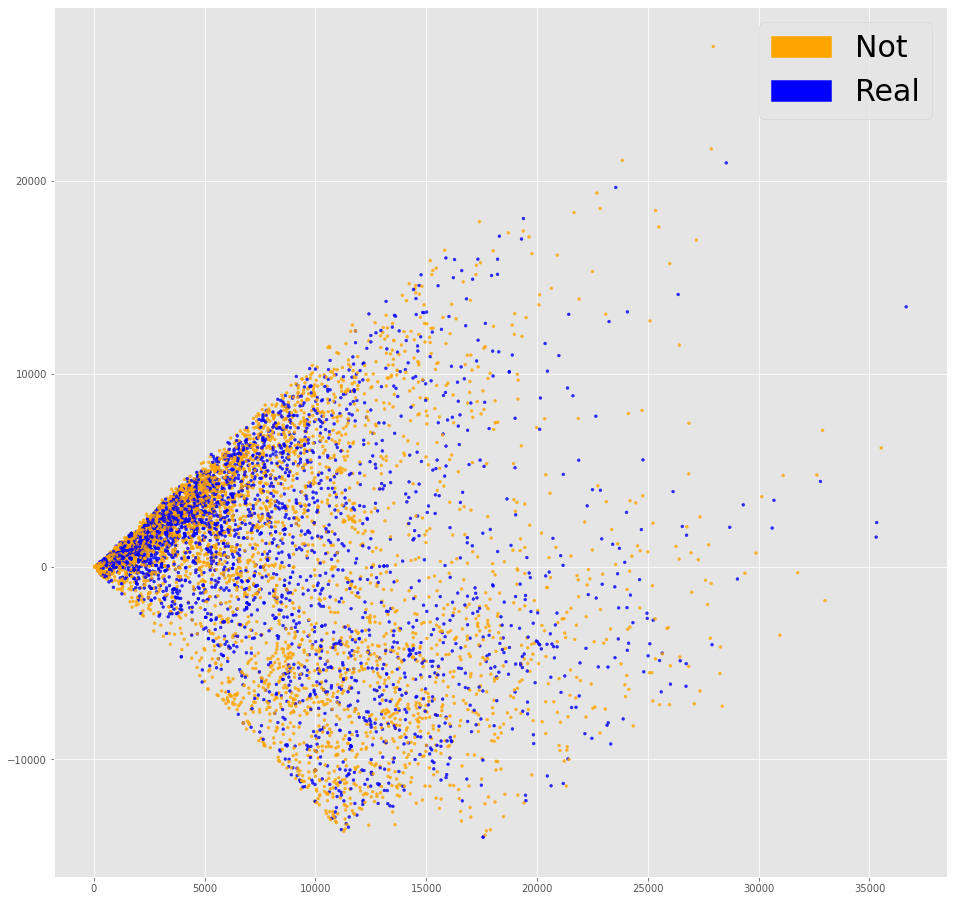

In [41]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(train,tweet['target'])
plt.show()

Training the model

In [42]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Epoch 1/10
1523/1523 - 98s - loss: 0.5443 - accuracy: 0.7407 - val_loss: 0.4591 - val_accuracy: 0.8096
Epoch 2/10
1523/1523 - 97s - loss: 0.4966 - accuracy: 0.7813 - val_loss: 0.4663 - val_accuracy: 0.8037
Epoch 3/10
1523/1523 - 98s - loss: 0.4849 - accuracy: 0.7796 - val_loss: 0.4503 - val_accuracy: 0.8063
Epoch 4/10
1523/1523 - 102s - loss: 0.4813 - accuracy: 0.7816 - val_loss: 0.4322 - val_accuracy: 0.8181
Epoch 5/10
1523/1523 - 97s - loss: 0.4724 - accuracy: 0.7901 - val_loss: 0.4202 - val_accuracy: 0.8227
Epoch 6/10
1523/1523 - 96s - loss: 0.4643 - accuracy: 0.7936 - val_loss: 0.4253 - val_accuracy: 0.8142
Epoch 7/10
1523/1523 - 97s - loss: 0.4601 - accuracy: 0.7943 - val_loss: 0.4204 - val_accuracy: 0.8240
Epoch 8/10
1523/1523 - 96s - loss: 0.4491 - accuracy: 0.8011 - val_loss: 0.4220 - val_accuracy: 0.8227
Epoch 9/10
1523/1523 - 96s - loss: 0.4426 - accuracy: 0.8015 - val_loss: 0.4163 - val_accuracy: 0.8247
Epoch 10/10
1523/1523 - 97s - loss: 0.4373 - accuracy: 0.8039 - val_loss

In [64]:
train_pred_GloVe = model.predict(train)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

In [70]:
train_pred_GloVe

array([[0.5249383 ],
       [0.97664416],
       [0.9758514 ],
       ...,
       [0.976577  ],
       [0.97637904],
       [0.97659314]], dtype=float32)

In [71]:
cm=confusion_matrix(train, train_pred_GloVe_int)
print(cm)

ValueError: ignored

In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
true = train_pred_GloVe_int
pred = train['target'].values
pred


In [ ]:
train= pd.read_csv('/content/gdrive/My Drive/NLP_Disaster_tweet_data/train.csv')
train['target'].values

In [ ]:
confusion_matrix(train_pred_GloVe_int, train['target'].values, labels=np.unique(y_true))